In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = "1"

In [2]:
import torch

print(torch.cuda.is_available())

True


In [3]:
text_doc = "resources/images/lightfootcat/images/extracted_text.txt"
divisions = ["Dicotyledones", "Monocotyledones", "Pteridophyta", "Hepaticae", "Algae"]#
prompt = "resources/prompts/lightfootcat_prompt.yaml"
images = "resources/images/lightfootcat/images/cropped/"

text_doc2 = "resources/images/hanbury/extracted_text.txt"
divisions2 = ["Dicotyledones", "GYMNOSPERMEAE", "Monocotyledones"]
prompt1 = "resources/prompts/hanbury_prompt.yaml"
images2 = "resources/images/hanbury/extracted_images/cropped"

In [4]:
from lib.model.ocr_model import OCRModel

ocr_model = OCRModel(prompt)

2025-08-27 15:46:33,216 - lib.utils.promptLoader - INFO - Loading prompt from resources/prompts/lightfootcat_prompt.yaml
2025-08-27 15:46:33,230 - lib.utils.promptLoader - INFO - Loading prompt from ./resources/settings.yaml
2025-08-27 15:46:33,247 - lib.model.base_model - INFO - Loading model: mistral7b with batch size: 1, max tokens: 4096, temperature: 0.01


/mnt/apps/users/ikarunak/conda/envs/dd_lcat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-08-27 15:46:36,783 - lib.model - INFO - Importing model: mistral7b
2025-08-27 15:46:36,783 - lib.model - INFO - Model imported successfully: mistral7b


In [5]:
import os
from natsort import natsorted
images_used = images
image_list = natsorted([os.path.join(images_used, im) for im in os.listdir(images_used)])

print(f"Number of images in {images_used}: {len(image_list)}")

Number of images in resources/images/lightfootcat/images/cropped/: 83


In [6]:
processed_images = ocr_model.process_images(image_list)

In [8]:
from PIL import Image
temp_dir = "./resources/images/temp_images/"
os.makedirs(temp_dir, exist_ok=True)

for idx, img in enumerate(processed_images):
    img = Image.fromarray(img)
    img.save(os.path.join(temp_dir, f"processed_{idx}.png"))

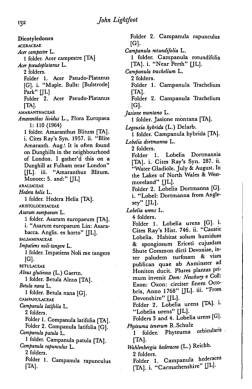

In [9]:
index_ = 0
sample = processed_images[index_]

import matplotlib.pyplot as plt

plt.imshow(sample, cmap='gray')
plt.axis('off')
plt.show()

### Layout parser

In [10]:
# import layoutparser as lp
# !curl -L https://www.dropbox.com/s/57zjbwv6gh3srry/model_final.pth?dl=1 -o ./resources/model_weights/mask_rcnn_X_101_32x8d_FPN_3x.pth
# model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
#                                  model_path='./resources/model_weights/mask_rcnn_X_101_32x8d_FPN_3x.pth',
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.4],
#                                  label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
#     # Load the deep layout model from the layoutparser API
#     # For all the supported model, please check the Model
#     # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html
# import cv2
# use_processed_ = False
# img = sample if use_processed_ else image_list[index_]

# if isinstance(img, str):
#     img = cv2.imread(img)
#     img = img[..., ::-1]   
# elif img.ndim == 2:                      # grayscale -> 3-channel
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# layout = model.detect(img)

### Deepdoctection

In [11]:
image_path = temp_dir#"./resources/images/lightfootcat/images/cropped/" #"resources/images/hanbury/extracted_images/"

[0827 15:47.15 @file_utils.py:31]  INF  PyTorch version 2.8.0+cu129 available.
[0827 15:47.15 @file_utils.py:69]  INF  Disabling Tensorflow because USE_TORCH is set
[0827 15:47.16 @dd.py:129]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_LINK': {'CHILD_CATEGORIES': [<LayoutType.CAPTION>],
                 'PARENTAL_CATEGORIES': [<LayoutType.FIGURE>, <LayoutType.TABLE>]},
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': [[<LayoutType.TABLE>, <LayoutType.TITLE>],
                                       [<LayoutType.TABLE>, <LayoutType.TEXT>],
                                       [<LayoutType.TABLE>, <LayoutType.KEY_VALUE_AREA>],
                                       [<LayoutType.TABLE>, <LayoutType.LIST_ITEM>],
                                       [<LayoutType.TABLE>, <LayoutType.LIST>],
                                       [<LayoutType.TABLE>, <LayoutType.FIGURE>],
                                       [<LayoutType.TITLE>, <LayoutType.TEXT>],
                  

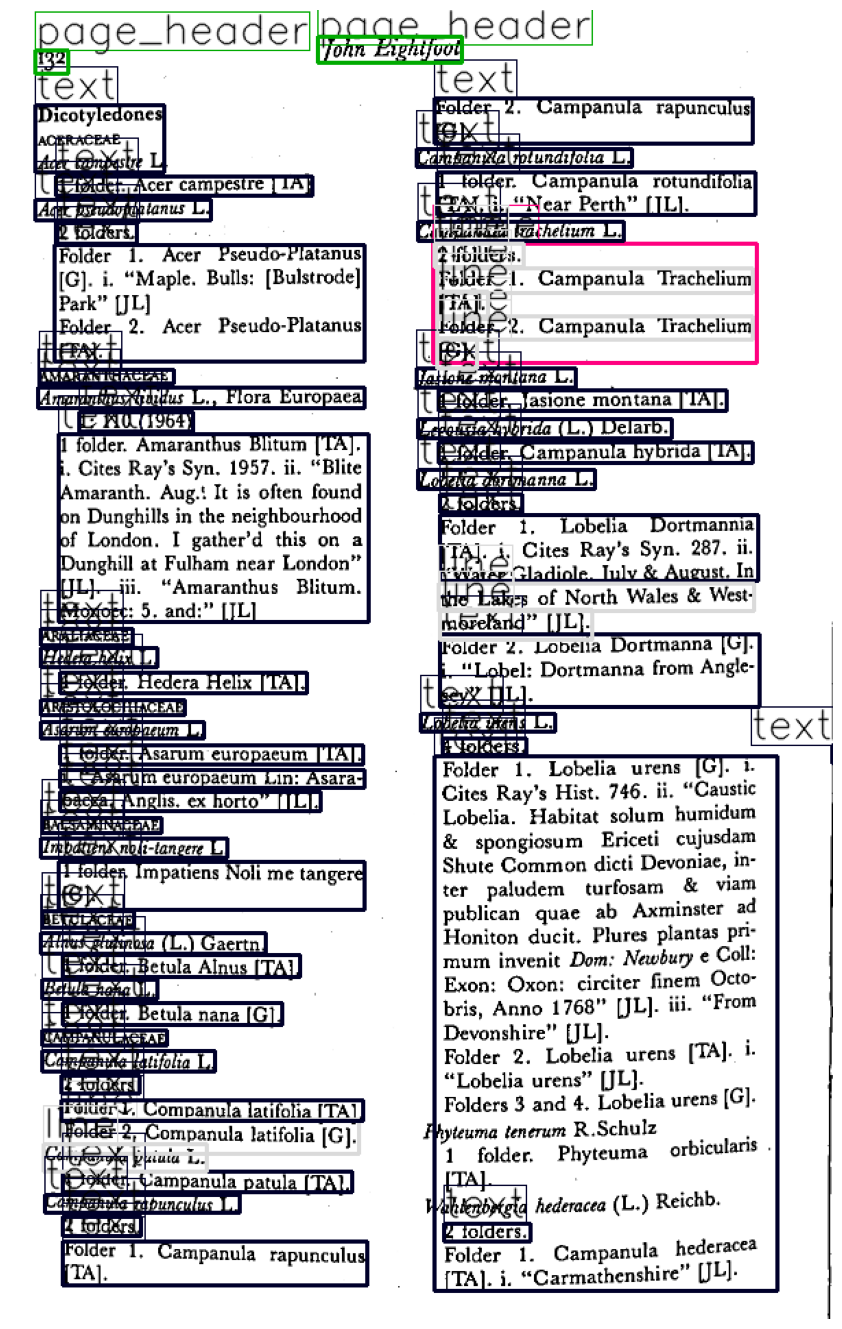

In [12]:
import deepdoctection as dd
from IPython.core.display import HTML
from matplotlib import pyplot as plt

config_overwrite = [
    "USE_TABLE_SEGMENTATION=False"
    #"TEXT_ORDERING.FLOATING_TEXT_BLOCK_CATEGORIES=['TEXT','TITLE','LIST','KEY_VALUE_AREA']",
    #"TEXT_ORDERING.HEIGHT_TOLERANCE=0.50",
    #"TEXT_ORDERING.STARTING_POINT_TOLERANCE=0.002",
    #"TEXT_ORDERING.BROKEN_LINE_TOLERANCE=0.0015",
    #"USE_LINE_MATCHER=True",
    #"WORD_MATCHING.MAX_PARENT_ONLY=True",
]

analyzer = dd.get_dd_analyzer(config_overwrite=config_overwrite)  # instantiate the built-in analyzer similar to the Hugging Face space demo

df = analyzer.analyze(path = image_path)  # setting up pipeline
df.reset_state()                 # Trigger some initialization

doc = iter(df)
page = next(doc) 

image = page.viz(show_figures=False, show_residual_layouts=True, show_cells=False)
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

In [13]:
page.residual_layouts

[Layout(active=True, _annotation_id='3f2cf7fe-d9d3-30c7-9a63-6ea1d01e57eb', service_id='5497d92c', model_id='af516519', session_id=None, category_name=<LayoutType.PAGE_HEADER>, _category_name=<LayoutType.PAGE_HEADER>, category_id=7, score=0.8417356014251709, sub_categories={}, relationships={<Relationships.CHILD>: ['93c472c7-9ae9-33e4-8f1d-0a54e6fc9173', '7307179e-21c2-3859-8993-cbc4469f33be']}, bounding_box=BoundingBox(absolute_coords=True, ulx=448, uly=39, lrx=659, lry=77, width=211, height=38)),
 Layout(active=True, _annotation_id='c177783e-2529-3e67-8db7-84a6f0d16ae4', service_id='5497d92c', model_id='af516519', session_id=None, category_name=<LayoutType.PAGE_HEADER>, _category_name=<LayoutType.PAGE_HEADER>, category_id=7, score=0.8373687863349915, sub_categories={}, relationships={<Relationships.CHILD>: ['9bc57eb7-3c1d-37d3-a0d6-ba4394acb2a0']}, bounding_box=BoundingBox(absolute_coords=True, ulx=37, uly=58, lrx=84, lry=92, width=47, height=34))]

Page dimensions: (36, 128), (1118, 1869)


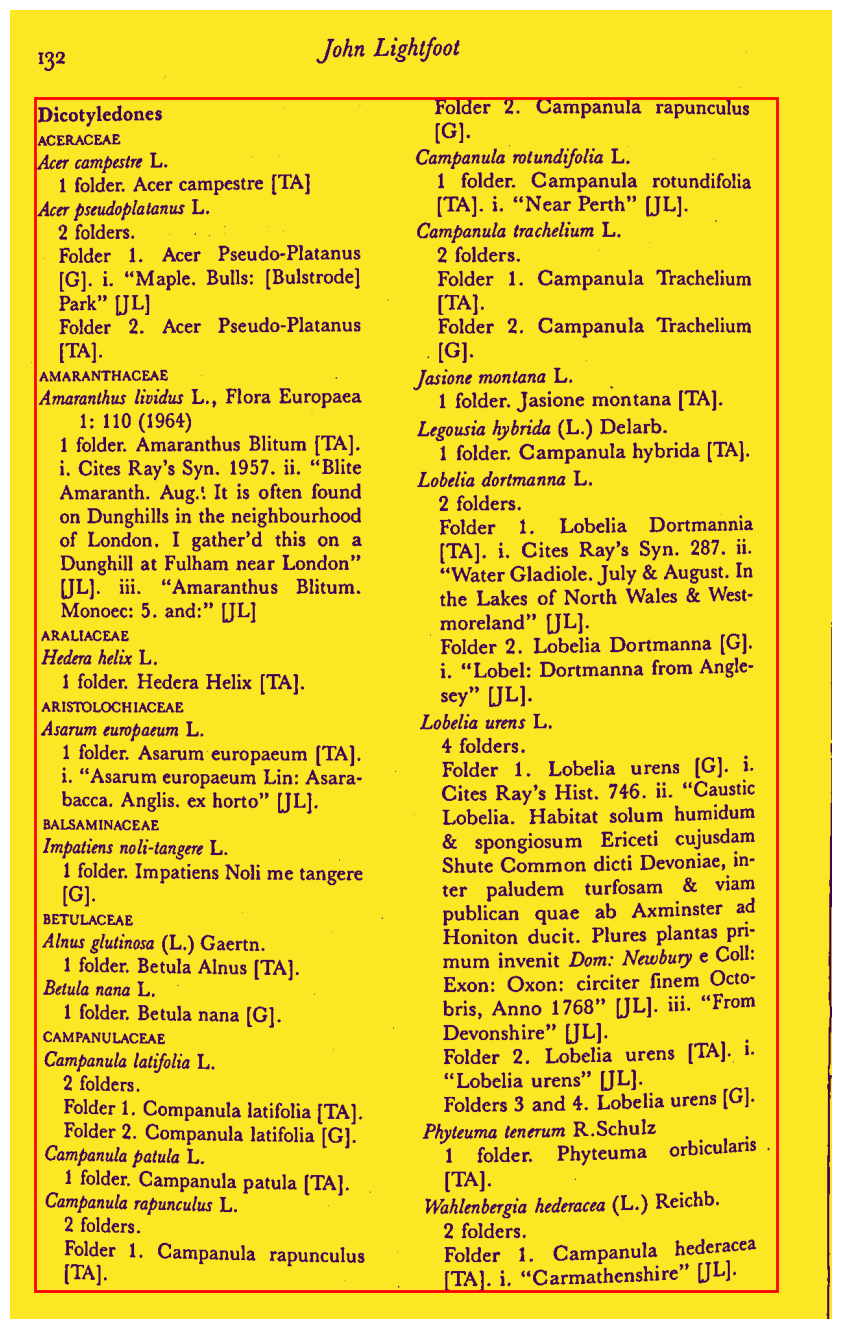

In [14]:
x1, y1, x2, y2 = None, None, None, None

for layout in page.layouts:
    bbox = layout.bbox#layout.bounding_box
    if layout.text == "":
        continue

    ulx, uly, lrx, lry = bbox#bbox.ulx, bbox.uly, bbox.lrx, bbox.lry

    x1 = ulx if x1 is None else min(x1, ulx)
    y1 = uly if y1 is None else min(y1, uly)
    x2 = lrx if x2 is None else max(x2, lrx)
    y2 = lry if y2 is None else max(y2, lry)

print(f"Page dimensions: ({x1}, {y1}), ({x2}, {y2})")
from PIL import Image
image = Image.open(page.location)

fig, ax = plt.subplots(1, figsize=(25,17))

rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.imshow(image)
plt.show()

[0827 15:56.13 @doctectionpipe.py:118]  INF  Processing processed_1.png
[0827 15:56.13 @context.py:154]  INF  ImageLayoutService total: 0.1858 sec.
[0827 15:56.13 @context.py:154]  INF  AnnotationNmsService total: 0.0015 sec.
[0827 15:56.14 @context.py:154]  INF  ImageLayoutService total: 0.1752 sec.
[0827 15:56.14 @context.py:154]  INF  TextExtractionService total: 0.4211 sec.
[0827 15:56.14 @context.py:154]  INF  MatchingService total: 0.0053 sec.
[0827 15:56.14 @context.py:154]  INF  TextOrderService total: 0.0259 sec.


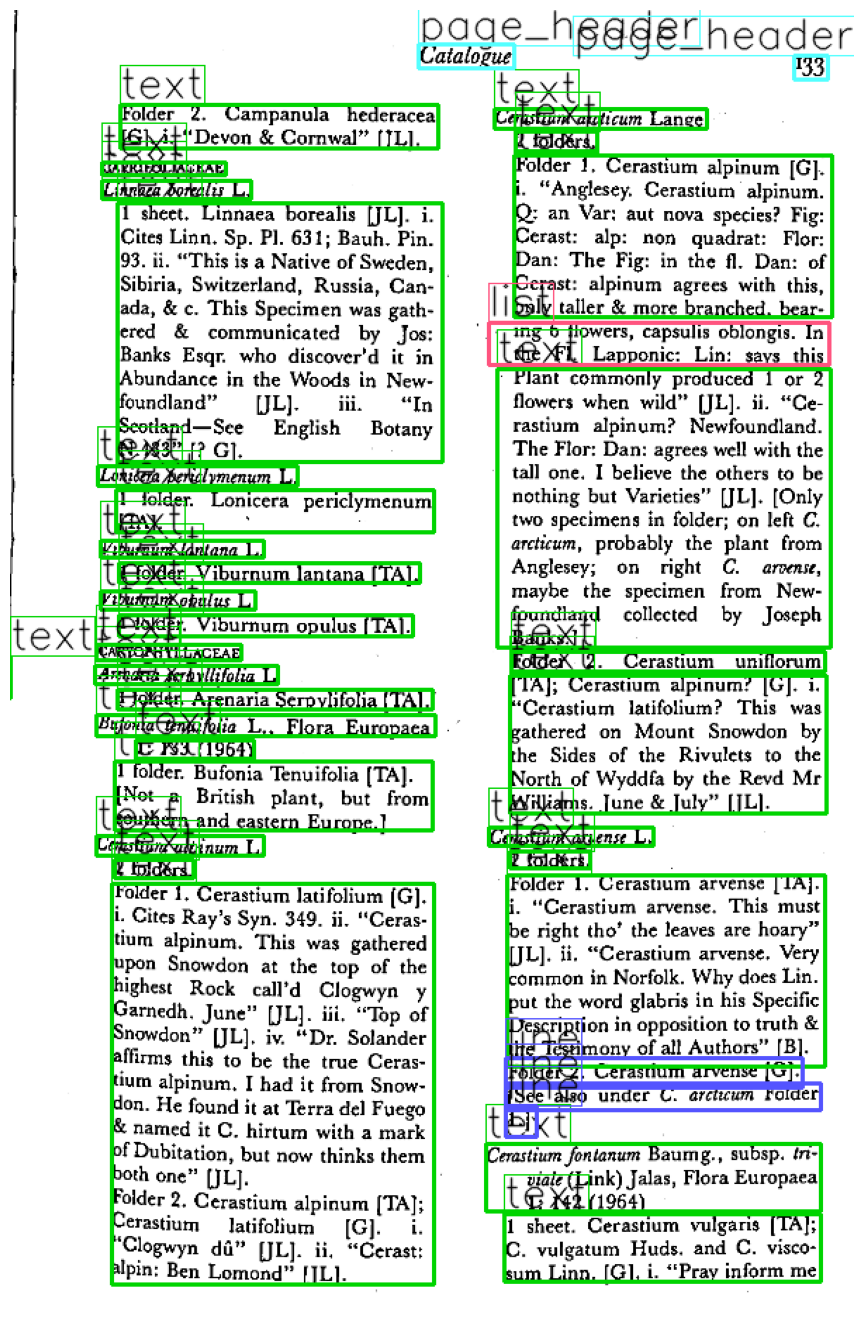

In [44]:
page = next(doc) 

image = page.viz(show_figures=True, show_residual_layouts=True, show_cells=False)
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

In [45]:
def get_midpoint(x1, y1, x2, y2):
    return (x1 + x2) / 2, (y1 + y2) / 2


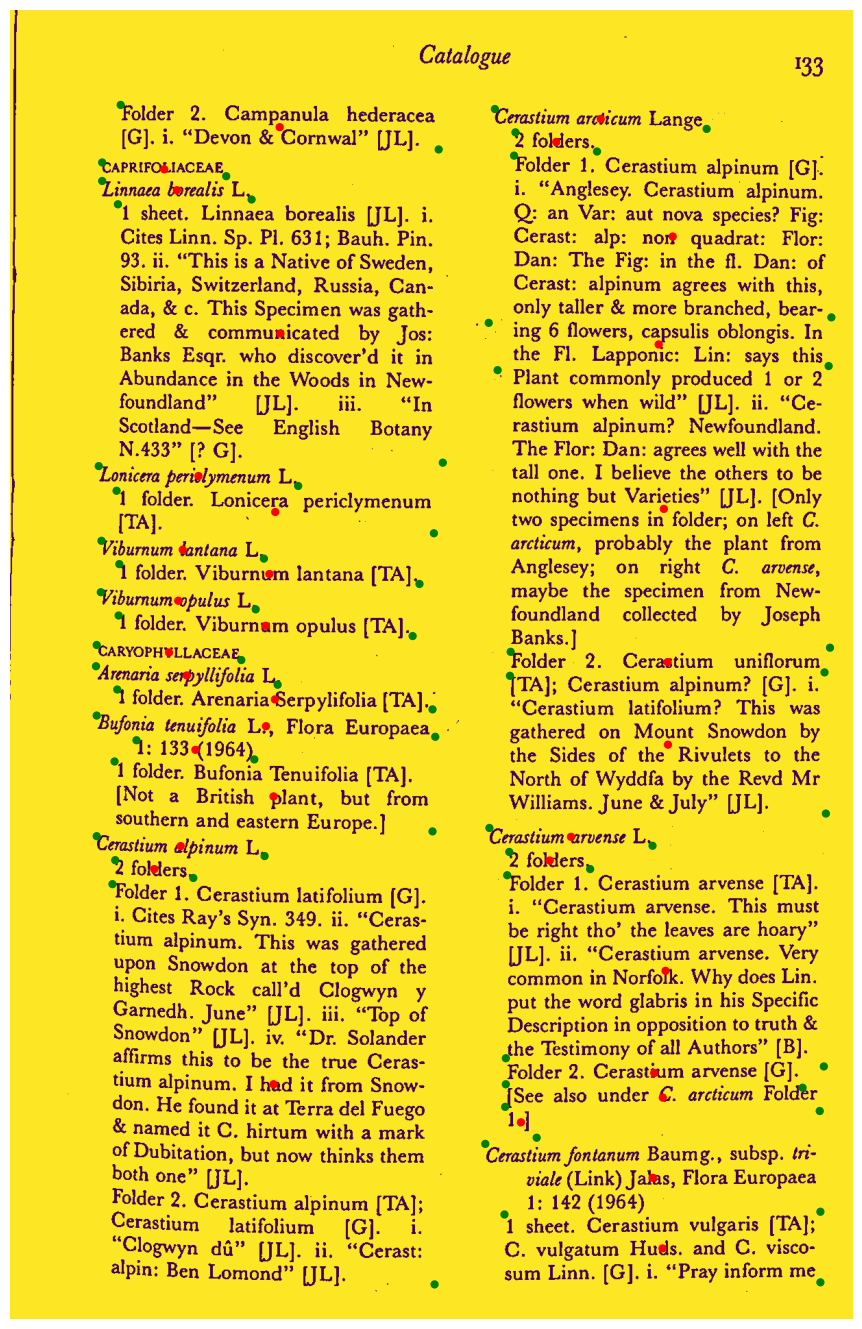

In [46]:
from PIL import Image
image = Image.open(page.location)

fig, ax = plt.subplots(1, figsize=(25,17))
bboxes = []
midpoints = []
for layout in page.layouts:
    bbox = layout.bbox#layout.bounding_box
    if layout.text == "":
        continue

    ulx, uly, lrx, lry = bbox#bbox.ulx, bbox.uly, bbox.lrx, bbox.lry
    bboxes.append([ulx, uly, lrx, lry])
    midpoint = get_midpoint(ulx, uly, lrx, lry)
    midpoints.append(midpoint)
    dot = plt.Circle(midpoint, 5, color='r')
    left = plt.Circle((ulx, uly), 5, color='g')
    right = plt.Circle((lrx, lry), 5, color='g')
    ax.add_patch(dot)
    ax.add_patch(left)
    ax.add_patch(right)

plt.axis('off')
plt.imshow(image)
plt.show()

In [47]:
from matplotlib.pylab import median
from numpy import diff
from sklearn.cluster import HDBSCAN
import numpy as np


mid_xs = np.array([midpoint[0] for midpoint in midpoints])
clustering = HDBSCAN(min_samples=min(10, len(mid_xs) // 2)).fit(mid_xs.reshape(-1, 1))

In [48]:
clustering.labels_

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [49]:
mid_xs

array([966.5, 951.5, 251.5, 394. , 384. , 956. , 274.5, 787. , 937.5,
       861.5, 818. , 386. , 210. , 796.5, 386.5, 372.5, 959.5, 257.5,
       373. , 384. , 378. , 248.5, 243. , 393. , 231.5, 270. , 953.5,
       245. , 959. , 224.5, 946. , 939.5, 952. , 745. ])

In [50]:
groups = {}

for idx, i in enumerate(clustering.labels_):
    if i not in groups:
        groups[i] = []
    groups[i].append(bboxes[idx])

print(groups)

{0: [[735, 212, 1198, 448], [721, 1757, 1182, 1856], [725, 1262, 1187, 1541], [728, 1228, 846, 1253], [693, 1654, 1182, 1753], [707, 144, 1016, 173], [699, 1193, 937, 1219], [737, 178, 856, 206], [729, 971, 1190, 1172], [711, 525, 1196, 930], [730, 936, 1188, 966], [698, 456, 1194, 519], [723, 1529, 1156, 1572], [723, 1567, 1181, 1606], [722, 1600, 768, 1645]], 1: [[133, 774, 370, 800], [157, 283, 631, 660], [149, 1275, 619, 1859], [129, 665, 420, 694], [156, 991, 616, 1020], [153, 1240, 267, 1266], [155, 701, 618, 763], [158, 883, 587, 913], [125, 957, 390, 984], [126, 1029, 620, 1060], [152, 1096, 616, 1198], [159, 808, 597, 837], [126, 1205, 371, 1234], [134, 249, 352, 276], [161, 138, 625, 203], [126, 926, 337, 948], [184, 1065, 356, 1093], [132, 849, 358, 874], [134, 222, 315, 242]]}


In [51]:
columns = []

def pad(box, perc=0.02):
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    x1 -= width * perc
    y1 -= height * perc
    x2 += width * perc
    y2 += height * perc
    return [x1, y1, x2, y2]

for group in groups:
    if group == -1:
        continue
    boxes = np.array(groups[group])
    x1 = min(boxes[:, 0])
    y1 = min(boxes[:, 1])
    x2 = max(boxes[:, 2])
    y2 = max(boxes[:, 3])
    columns.append(pad([x1, y1, x2, y2]))

In [52]:
columns

[[682.9, 109.75999999999999, 1208.1, 1890.24],
 [114.88, 103.58, 641.12, 1893.42]]

In [53]:
def iou(box1, box2, thresh=0, eps=1e-5):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y3 = min(box1[3], box2[3])

    overlap_w = max(0, x2 - x1)
    overlap_h = max(0, y3 - y1)
    overlap_area = overlap_w * overlap_h

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou_val = overlap_area / (box1_area + box2_area - overlap_area + eps)
    print(iou_val)
    return iou_val > thresh


def merge_boxes(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return [x1, y1, x2, y2]



def merge_columns(columns):
    columns_sorted = sorted(columns, key=lambda x: x[0])
    merged_columns = []

    for box in columns_sorted:
        if len(merged_columns) == 0:
            merged_columns.append(box)
        else:
            if iou(merged_columns[-1], box):
                merged_columns[-1] = merge_boxes(merged_columns[-1], box)
            else:
                merged_columns.append(box)
    return merged_columns

In [54]:
print(columns)
merged_columns = merge_columns(columns)
print(merged_columns)
merged_columns = merge_columns(merged_columns)
print(merged_columns)

[[682.9, 109.75999999999999, 1208.1, 1890.24], [114.88, 103.58, 641.12, 1893.42]]
0.0
[[114.88, 103.58, 641.12, 1893.42], [682.9, 109.75999999999999, 1208.1, 1890.24]]
0.0
[[114.88, 103.58, 641.12, 1893.42], [682.9, 109.75999999999999, 1208.1, 1890.24]]


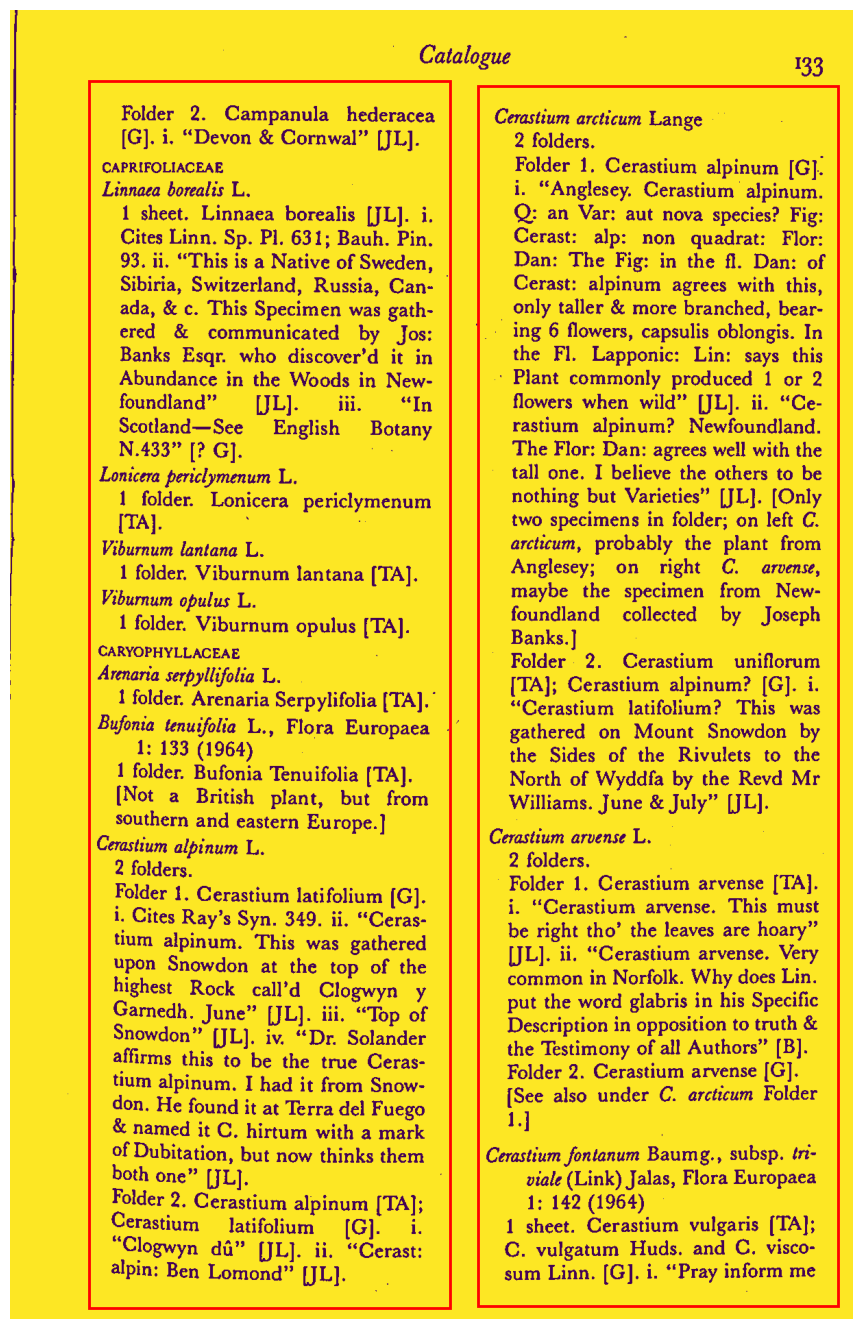

In [55]:
fig, ax = plt.subplots(1, figsize=(25,17))

ax.imshow(image)
for box in merged_columns:
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()

Page dimensions: (125, 138), (1198, 1859)


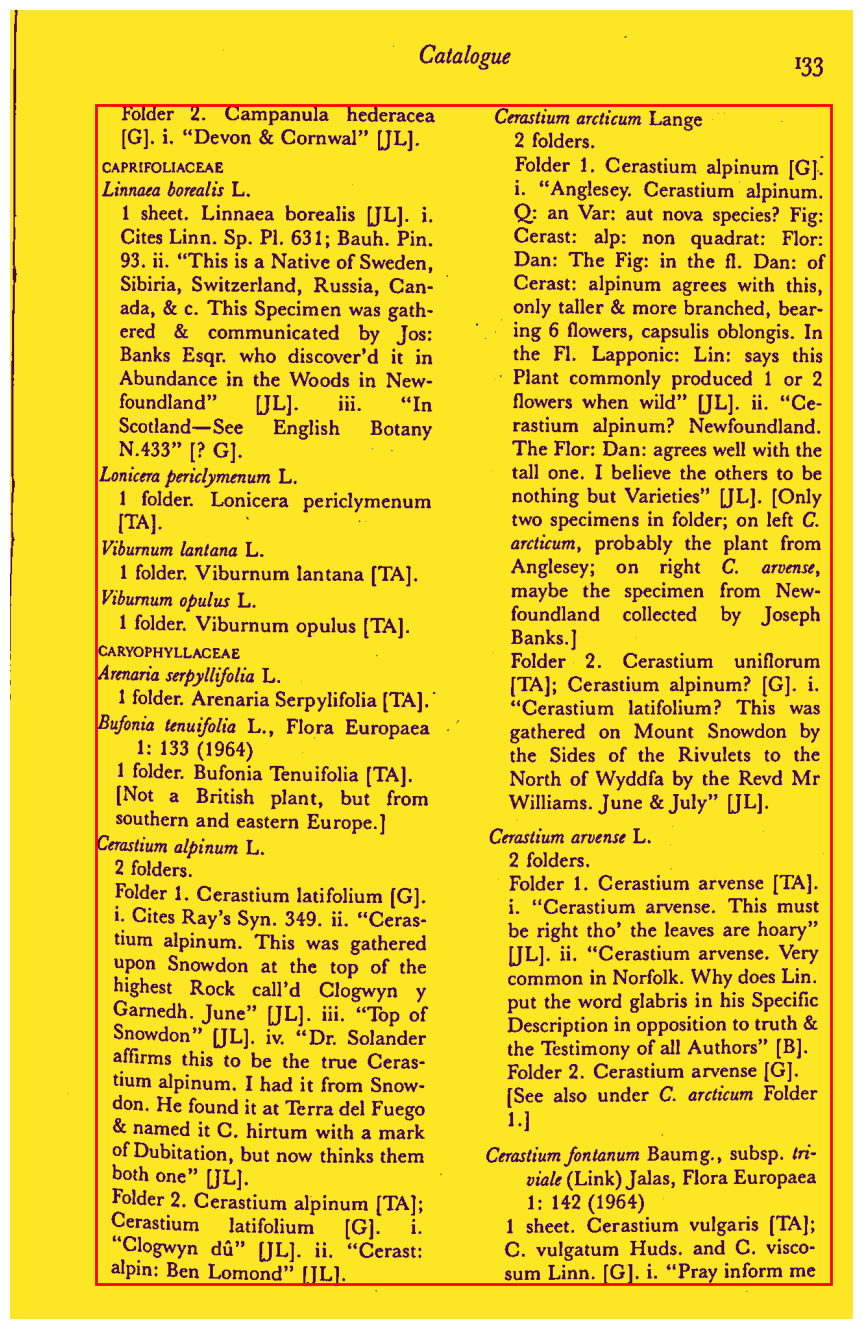

In [27]:
x1, y1, x2, y2 = None, None, None, None

for layout in page.layouts:
    bbox = layout.bbox#layout.bounding_box
    if layout.text == "":
        continue

    ulx, uly, lrx, lry = bbox#bbox.ulx, bbox.uly, bbox.lrx, bbox.lry

    x1 = ulx if x1 is None else min(x1, ulx)
    y1 = uly if y1 is None else min(y1, uly)
    x2 = lrx if x2 is None else max(x2, lrx)
    y2 = lry if y2 is None else max(y2, lry)

print(f"Page dimensions: ({x1}, {y1}), ({x2}, {y2})")
from PIL import Image
image = Image.open(page.location)

fig, ax = plt.subplots(1, figsize=(25,17))

rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.imshow(image)
plt.show()

In [56]:
from typing import Union
import cv2
from natsort import natsorted
import os
import numpy as np
from lib.utils import get_logger
logger = get_logger(__name__)
import tempfile
from pathlib import Path
import shutil
from PIL import Image
from sklearn.cluster import HDBSCAN
import deepdoctection as dd

class LayoutDetection:
    CONFIG_OVERWRITE = [
        "USE_TABLE_SEGMENTATION=False"
    ]
    def __init__(self):

        self.analyser = dd.get_dd_analyzer(config_overwrite=self.CONFIG_OVERWRITE)  # instantiate the built-in analyzer similar to the Hugging Face space demo

        pass

    def process_image(self, image: Union[str, np.ndarray]) -> np.ndarray:
        """
        Process a single image for OCR extraction.
        This includes converting to grayscale, removing shadows, denoising, binarization, and morphological operations.

        Parameters:
            image (str or np.ndarray): Path to the image or the image itself as a numpy array

        Returns:
            np.ndarray: Processed image ready for OCR extraction
        """
        assert isinstance(image, (str, np.ndarray)), "Image must be a file path or a numpy array."

        if isinstance(image, str):
            image = cv2.imread(image)

        logger.debug("Step 1: Grayscale Conversion")
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        logger.debug("Step 2: Gaussian Blur")
        blurred = cv2.GaussianBlur(gray_image, (3, 3), 0)

        logger.debug("Step 2: Remove shadows")
        thresh = cv2.adaptiveThreshold(blurred, 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 41, 10)

        logger.debug("Step 3: Noise Reduction")
        denoised_image = cv2.bilateralFilter(thresh, 9, 75, 75)

        # logger.debug("Step 4: Binarization (black and White) via Otsu's method")
        # binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # logger.debug("Step 5: Deskewing")
        # logger.debug("Skipping deskewing for now")
        # deskewed_image = binarized_image

        # logger.debug("Step 6: Morphological opening (erosion followed by dilation)")
        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        # opened_image = cv2.morphologyEx(deskewed_image, cv2.MORPH_OPEN, kernel, iterations=1)

        logger.debug("Step 7: Optional dilation to thicken strokes")
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        processed_image = cv2.dilate(denoised_image, kernel2, iterations=1)

        return processed_image

    def process_images(self, images: list[str], save: bool = False, save_path : str="./resources/images/temp_images") -> np.ndarray:
        """
        Process a list of images for OCR extraction.

        Args:
            images (list[str]): List of image file paths.
            save (bool, optional): If True, processed images will be saved to disk. Defaults to False.

        Returns:
            np.ndarray: Array of processed images.
        """
        save_dir  = Path(save_path)
        if save:
            if save_dir.exists():
                shutil.rmtree(save_path)
            save_dir.mkdir(parents=True, exist_ok=True)


        processed_images = []
        for image in images:
            processed = self.process_image(image)
            processed_images.append(processed)

            if save:
                img = Image.fromarray(processed)
                img_name = image.split(os.sep)[-1]
                img.save(os.path.join(save_dir, img_name))

        return processed_images


    def get_midpoint(self, box: list[float]) -> tuple[float, float]:
        """
        Return the midpoint of the bounding box

        Args:
            box (list[float]): Bounding box

        Returns:
            tuple[float, float]: Midpoint of the bounding box
        """
        x1,y1,x2,y2 = box
        return (x1 + x2) / 2, (y1 + y2) / 2
    

    def pad(self, box: list[float], perc: float = 0.02) -> list[float]:
        """
        Add padding to the bounding box

        Args:
            box (list[float]): Bounding Box
            perc (float, optional): Padding percentage. Defaults to 0.02.

        Returns:
            list[float]: Padded Bounding Box
        """
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        x1 -= width * perc
        y1 -= height * perc
        x2 += width * perc
        y2 += height * perc
        return [x1, y1, x2, y2]

    
    def iou(self, box1: list[float], box2: list[float], thresh: float=0.0, eps: float=1e-5) -> list[float]:
        """
        Calculate the intersection over union metric, basically the overlap percentage, between two boxes.

        Args:
            box1 (list[float]): Bounding Box 1
            box2 (list[float]): Bounding Box 2
            thresh (float, optional): Threshold for IoU. Defaults to 0.0.
            eps (float, optional): Small value to avoid division by zero. Defaults to 1e-5.

        Returns:
            list[float]: Intersection over Union (IoU) value.
        """
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y3 = min(box1[3], box2[3])

        overlap_w = max(0, x2 - x1)
        overlap_h = max(0, y3 - y1)
        overlap_area = overlap_w * overlap_h

        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        iou_val = overlap_area / (box1_area + box2_area - overlap_area + eps)
        return iou_val > thresh


    def merge_boxes(self, box1: list[float], box2: list[float]) -> list[float]:
        """
        Merge two bounding boxes into one bounding box

        Args:
            box1 (list[float]): Bounding box 1
            box2 (list[float]): Bounding box 2

        Returns:
            list[float]: Merged bounding box
        """
        x1 = min(box1[0], box2[0])
        y1 = min(box1[1], box2[1])
        x2 = max(box1[2], box2[2])
        y2 = max(box1[3], box2[3])
        return [x1, y1, x2, y2]



    def merge_columns(self, columns: list[list[float]]) -> list[list[float]]:
        """
        Merge overlapping columns into single columns

        Args:
            columns (list[list[float]]): List of bounding boxes representing columns

        Returns:
            list[list[float]]: List of merged bounding boxes
        """
        columns_sorted = sorted(columns, key=lambda x: x[0])
        merged_columns = []

        for box in columns_sorted:
            if len(merged_columns) == 0:
                merged_columns.append(box)
            else:
                if self.iou(merged_columns[-1], box):
                    merged_columns[-1] = self.merge_boxes(merged_columns[-1], box)
                else:
                    merged_columns.append(box)
        return merged_columns


    def __call__(self, images: list[str], save_path: str="./resources/images/temp_images/"):
        
        # Pre-process the image and save them into a temp folder
        _ = self.process_images(images, save=True, save_path=save_path)

        analysed_folder = self.analyser.analyze(path=save_path)
        analysed_folder.reset_state()
        doc = iter(analysed_folder)

        final_images = []

        for page in doc:
            bboxes = []
            midpoints = []

            for layout in page.layouts:
                if layout.text == "":
                    continue
                bbox = layout.bbox

                bboxes.append(bbox)
                midpoints.append(self.get_midpoint(bbox))

            mid_xs = np.array([midpoint[0] for midpoint in midpoints])
            clustering = HDBSCAN(min_samples=min(10, len(mid_xs) // 2)).fit(mid_xs.reshape(-1, 1))
            
            groups = {}

            for idx, i in enumerate(clustering.labels_):
                if i not in groups:
                    groups[i] = []
                groups[i].append(bboxes[idx])

            columns = []
            for group in groups:
                if group == -1:
                    continue
                boxes = np.array(groups[group])
                x1 = min(boxes[:, 0])
                y1 = min(boxes[:, 1])
                x2 = max(boxes[:, 2])
                y2 = max(boxes[:, 3])
                columns.append(self.pad([x1, y1, x2, y2]))

            merged_columns = sorted(self.merge_columns(columns), key=lambda x: x[0])
            
            image = Image.open(page.location)
            
            for col in merged_columns:
                cropped_column = image.crop((col[0], col[1], col[2], col[3]))
                final_images.append(cropped_column)
        
        save_dir = Path(save_path)

        # Removing temporary images
        shutil.rmtree(save_path)

        return final_images

In [57]:
ld = LayoutDetection()

image_list = natsorted([os.path.join(images, im) for im in os.listdir(images)])
final_images = ld(image_list)

[0827 15:56.47 @dd.py:129]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_LINK': {'CHILD_CATEGORIES': [<LayoutType.CAPTION>],
                 'PARENTAL_CATEGORIES': [<LayoutType.FIGURE>, <LayoutType.TABLE>]},
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': [[<LayoutType.TABLE>, <LayoutType.TITLE>],
                                       [<LayoutType.TABLE>, <LayoutType.TEXT>],
                                       [<LayoutType.TABLE>, <LayoutType.KEY_VALUE_AREA>],
                                       [<LayoutType.TABLE>, <LayoutType.LIST_ITEM>],
                                       [<LayoutType.TABLE>, <LayoutType.LIST>],
                                       [<LayoutType.TABLE>, <LayoutType.FIGURE>],
                                       [<LayoutType.TITLE>, <LayoutType.TEXT>],
                                       [<LayoutType.TEXT>, <LayoutType.KEY_VALUE_AREA>],
                                       [<LayoutType.TEXT>, <LayoutType.LIST_ITEM>],
          

In [73]:
from jdeskew.estimator import get_angle

from jdeskew.utility import rotate

2.3789649415692824
0.976627712854759
-0.27545909849749606
-1.9782971619365615
-0.02504173622704542
-0.02504173622704542
-0.6260434056761266
-1.4273789649415691
1.026711185308848
0.37562604340567596
-0.27545909849749606
-1.1769616026711187


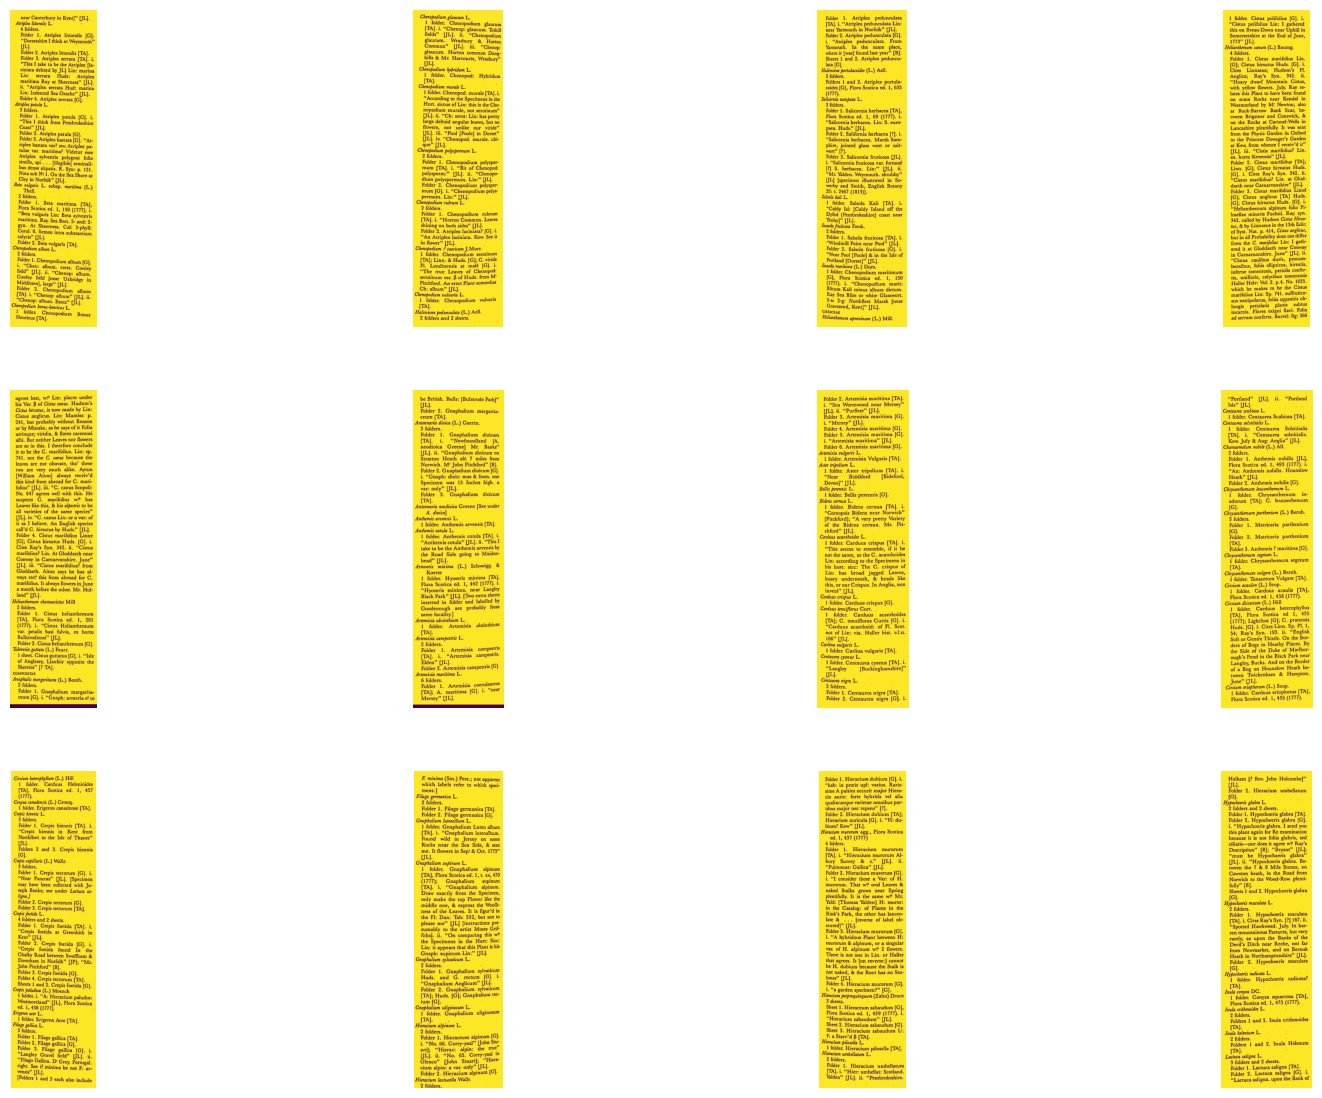

In [80]:
next = 12
images_to_view = final_images[next:next+12]

fig, ax = plt.subplots(3, 4, figsize=(20, 14))

for idx, image in enumerate(images_to_view):
    image_array = np.array(image)
    angle = get_angle(image_array)
    print(angle)
    print_image = rotate(image_array, angle)
    ax[idx // 4, idx % 4].imshow(image_array)
    ax[idx // 4, idx % 4].axis("off")

plt.show()

In [83]:
"""TODO:
1. Create a class file for Layout detection
2. Use Tesseract OCR and or QWEN model for OCR
3. Checkout GPT OSS 120B for species detection and organisation  
"""

'TODO:\n1. Create a class file for Layout detection\n2. Use Tesseract OCR and or QWEN model for OCR\n3. Checkout GPT OSS 120B for species detection and organisation  \n'